# Beamforming - Contre-mesures RADAR

## Situation

### Maxime BARRET


Avec l'aide de :
#### 'Signaux et Sytèmes' - Prof. Dr Ir Xavier Neyt 
#### 'Source Localization with sensor arrays' - Assistant Professors Charles Vanwynsberghe & Angélique Drémeau


### Les deux notebooks précédents illustrent respectivement : 
- L'estimation de la direction d'arrivée d'un signal et la comparaison de différentes méthodes (Justesse, faux-positif, non-détection, robustesse de la méthode au mouvement)
- La mise en place d'une situation s'approchant de la réalité et introduire le principe d'émission dans une certaine direction. 

### Le but est à présent de mettre en place une situation combinant les deux
c.f. Mail du 13 Août 2020

Nous aurons un système mobile, et deux systèmes RADAR. 
Les deux systèmes RADAR envoient chacun un signal ($s1$ et $s2$ respectivement), ces signaux étant corrélés.
Au niveau de notre système mobile, nous recevons $s0$. 
Par rapport à chaque RADAR, le système mobile est respectivement à $ \theta_0 $ et $ \theta_1 $.

In [1]:
%matplotlib notebook
#Indique qu'on va afficher des figures, et permet de les modifier

from BeamformingMethods import a
import numpy as np    #Permet de manipuler plus facilement des arrays, matlab-like
import matplotlib.pyplot as plt   #Affichage des courbes
import numpy.random as rd     
from scipy.signal import find_peaks   #Fonction permettant d'obtenir les positions des pics sur une courbe
import time   #Apporte des fonctionnalités de temps, pour par exemple comparer les temps de calculs
import warnings 
import scipy

#Imports d'usage

In [2]:
N=5   #J'ai N éléments dans mon ULA
l=0.3  #longueur d'onde
d = l/2 #distance entre mes antennes élémentaires

s=[]
for a in range(N):
    if a%2==0:
        s.append(-1)
    else:
        s.append(1)
#s=[np.exp(1j*np.pi*j) for j in range(N) ]

theta1 = 20/180*np.pi   #Angle où sont situés deux sources, en rad
theta2 = 40/180*np.pi

dphi1 = 2*np.pi*d*np.sin(theta1)/l   #Déphasage induit par l'Angle of Arrival (AoA) 
dphi2 = 2*np.pi*d*np.sin(theta2)/l

theta = np.linspace(-np.pi/2,np.pi/2,181)   #Grille d'angles

n = np.arange(0,N,1).T  #Correspond à la 'liste' de nos antennes élémentaires

s1 = np.exp(1j*dphi1*n)  
s2 = np.exp(1j*dphi2*n)  


y = s + s1+ s2

Le but ici est d'étudier la matrice $\mathbf{R} = \mathbf{E}(\mathbf{s}_0 *\mathbf{s}_0 ^t  )$, qui est calculée à partir de ce qui est reçu. 

La structure de cette matrice dépend de plusieurs facteurs : 
- Il y a t'il du bruit
- Les signaux composants s0 sont-ils corrélés

Si la structure est simple, comme c'est le cas si les signaux s1 et s2 ne sont pas corrélés, alors les directions d'arrivées _(DoA)_ peuvent être trouvées aisément.
En complexifiant la structure, nous rendons l'obtention des DoA plus compliquée. 

In [3]:
def v2m(v1,v2):  #Cette fonction remplace la syntaxe matlab " v1*v2' "
    L = len(v1)
    res = np.zeros((L,L),dtype=complex)
    for i in range(L):
        for j in range(L):
            res[i,j] = v1[i]*v2[j]
    return res

Construisons R dans le cas où les sources ne sont pas corrélées : 

In [14]:
R1 = np.zeros((N,N))
K1 = 1000
for k in range(K1):

    a1 = rd.randn() + 1j * rd.randn();    #Comme le code matlab, mais les signaux ne seront pas corrélés.
    a2 = rd.randn() + 1j * rd.randn();
    
    nn1 = a1*v2m(s1,s1.T) +a2*v2m(s2,s2.T) + 0.01*(rd.randn(N,1)+1j*rd.randn(N,1))
    R1 = R1 + nn1@nn1.T

R1=R1/K1

Construisons R dans le cas où les sources sont corrélées : 

In [15]:
R = np.zeros((N,N))
K = 1000
for k in range(K):
    
    
    a1 = 4*np.exp(1j*k*l) #Je créé les coefficients de mes signaux, de telle sorte à ce qu'ils soient corrélés.
    a2 = 4*np.exp(1j*(k*l + np.pi))
    
   
    nn = a1*v2m(s1,s1.T) +a2*v2m(s2,s2.T) + 0.05*(rd.randn(N,1)+1j*rd.randn(N,1))
    nn = nn + v2m(s1.T,s2) + v2m(s2,s1.T)  #car signaux corrélés
    R = R + nn@nn.T

R=R/K

In [16]:
CPN1 = []
CPN = []
for i in theta:
    dphi = 2*np.pi*d*np.sin(i)/l
    steer = np.exp(1j*dphi*n)
    
    R1_inv = np.linalg.inv(R1)
    w1 = R1_inv@steer
    CPN1.append(1/((steer.T@R1_inv@steer)))
    
    R_inv = np.linalg.inv(R)
    w = R_inv@steer
    CPN.append(1/(steer.T@R_inv@steer))
    
    

## Sources non corrélées

<IPython.core.display.Javascript object>


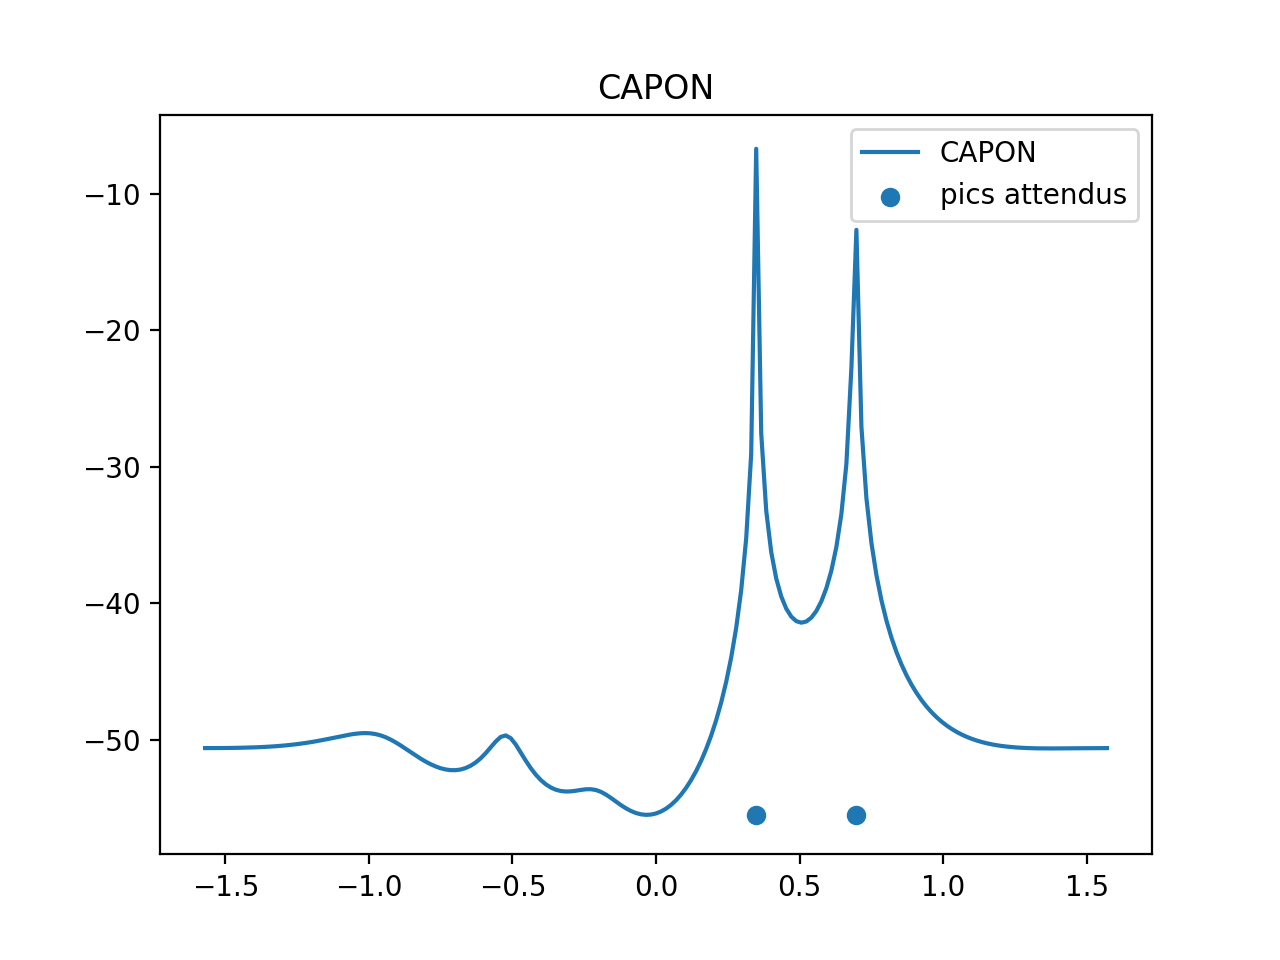

In [17]:
plt.figure()
plt.title("CAPON")
plt.plot(theta,10*np.log10(CPN1),label="CAPON")
plt.scatter([0.349,0.698],2*[np.min(10*np.log10(CPN1))],label='pics attendus')
plt.legend()

Les directions sont bien indiquées par la méthode CAPON. Voyons ce maintenant ce que la corrélation des sources apporte.

## Sources corrélées

<IPython.core.display.Javascript object>


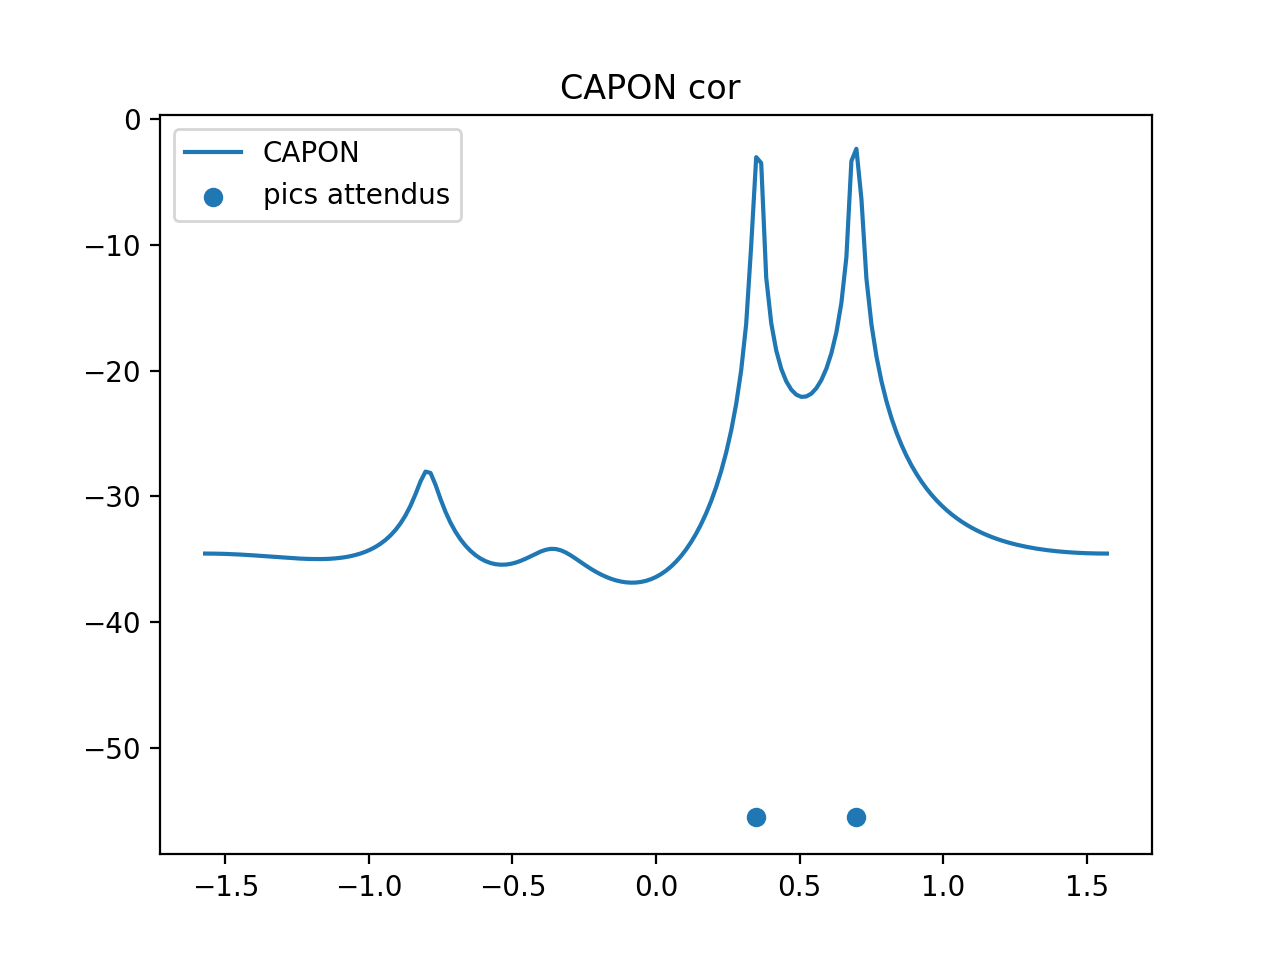

In [18]:
plt.figure()
plt.title("CAPON cor ")
plt.plot(theta,10*np.log10(CPN),label="CAPON")
plt.scatter([0.349,0.698],2*[np.min(10*np.log10(CPN1))],label="pics attendus")
plt.legend()

## Nous nous rendons compte qu'en complexifiant R, __on obtient d'autres pics !__